# Visualizing A* on the semester graph
This notebook shows how to build a simple semester graph, run A* to find a path from your next semester to semester 8, and visualize the result.

In [20]:
# Setup: imports and parameters (aligned with test_smart_course_planner.py)
import importlib
import networkx as nx
import matplotlib.pyplot as plt
import model.smart_course_planner as scp
importlib.reload(scp)

# Inputs
interests = ["machine learning", "AI"]
career_goal = "data scientist"
current_semester = 3
start_sem = current_semester + 1
courses_taken = ['MII21-1201','MII21-1203','MII21-2401','MII21-1002']

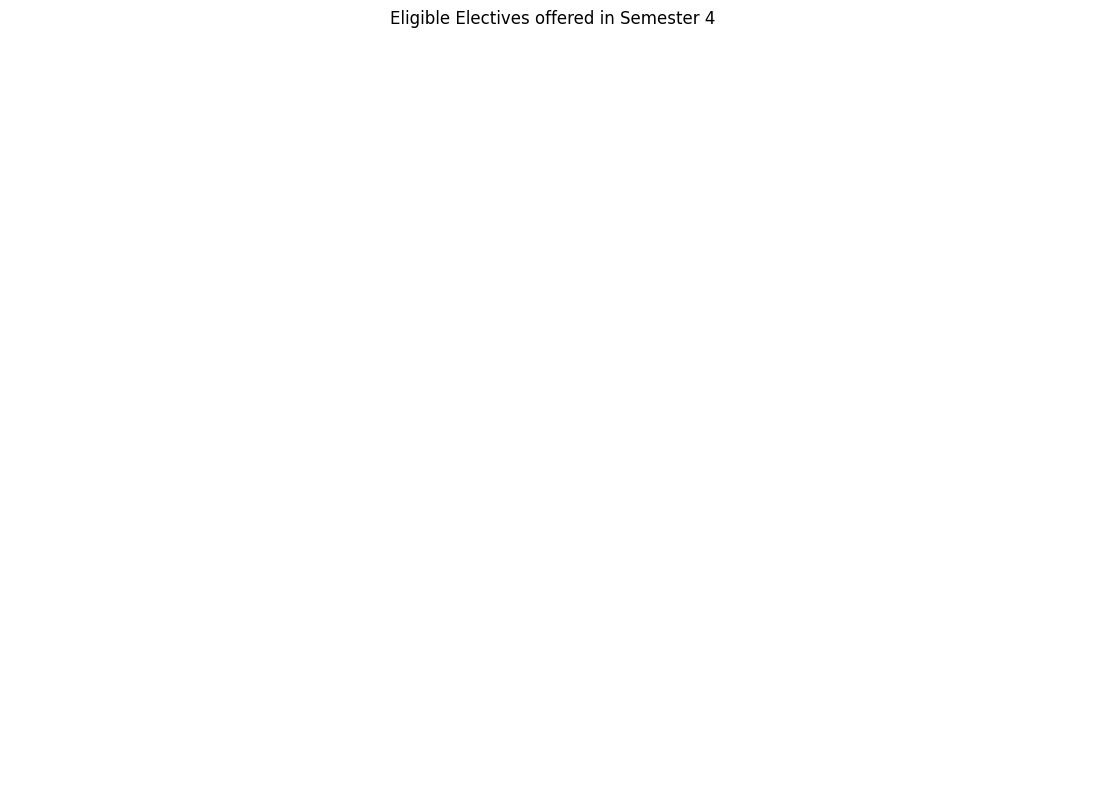

In [21]:
# Build graph and eligible candidates based on 'taken'
courses, prereqs, career_keywords, lab_preferences = scp.load_knowledge()
graph = scp.build_course_graph(courses, prereqs, interests, career_goal, career_keywords, lab_preferences)
course_map = {c.get("course_code"): c for c in courses if c.get("course_code")}

# Candidates: elective-only, offered in this semester, prereqs satisfied, not yet taken
taken = set(courses_taken)
eligible_candidates = [
    code for code in course_map.keys()
    if scp.is_elective(course_map.get(code, {}))
    and scp.offered_in_semester(course_map.get(code, {}), start_sem)
    and scp.prereq_ok(code, taken, prereqs)
    and code not in taken
]

# Build a NetworkX subgraph for eligible nodes to visualize
graph_sub = {u: [(v, cost) for (v, cost) in graph.get(u, []) if v in eligible_candidates] for u in eligible_candidates}
G = nx.DiGraph()
for u, neighbors in graph_sub.items():
    for v, cost in neighbors:
        G.add_edge(u, v, weight=cost)

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G, pos, node_size=500, node_color="#cfe8ff", edgecolors="#1f4b99")
nx.draw_networkx_labels(G, pos, labels={n: n for n in G.nodes()}, font_size=8)
nx.draw_networkx_edges(G, pos, edge_color="#999999", arrows=True, arrowsize=12, width=1.0)
edge_labels = {(u, v): f'{d.get("weight", 1):.2f}' for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
plt.title(f"Eligible Electives offered in Semester {start_sem}")
plt.axis("off")
plt.show()

Candidate comparison (sorted by cost asc, then score desc):
- MII21-2404: cost=0.0400, score=30.00, start=MII21-1002
- MII21-2405: cost=0.0533, score=30.00, start=MII21-2401
- MII21-2205: cost=0.0833, score=12.00, start=None
- MII21-3512: cost=0.0875, score=16.00, start=MII21-1203
- MII21-2608: cost=100000.0000, score=0.00, start=None
- MII21-2611: cost=300000.0000, score=0.00, start=MII21-1203

Chosen course for semester 4: MII21-2404 (cost=0.0400, score=30.00, start=MII21-1002)


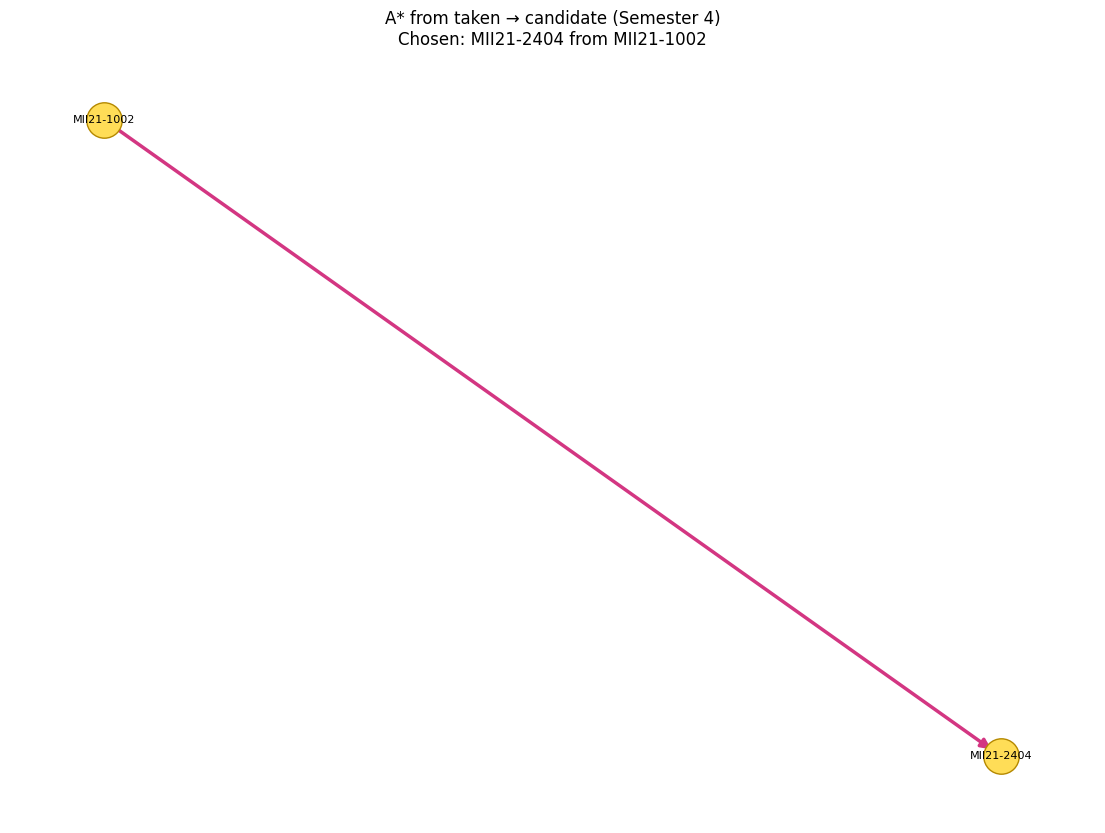

In [22]:
# A* selection: evaluate from each taken course to each eligible candidate
import heapq

def course_score(code):
    return scp.score_course(course_map.get(code, {}), interests, career_goal, career_keywords, lab_preferences)

def own_cost(code):
    sc = course_score(code)
    depth = scp.prereq_depth(prereqs, code)
    return (1.0 + 0.2 * depth) / (sc + 1e-5)

# Define starts as the taken courses that appear in the graph
start_nodes = [s for s in courses_taken if s in graph]

# Evaluate best path for each candidate from any taken start
comparisons = []  # list of dicts for display
best = None  # tuple: (cost, -score, code, start, path)

for code in eligible_candidates:
    best_cost = float('inf')
    best_start = None
    best_path = None
    for s in start_nodes:
        p = scp.astar(graph, s, code, prereqs)
        if not p:
            continue
        # cost of path; if trivial (unlikely here), use own_cost
        cst = scp.path_cost(graph, p) if len(p) > 1 else own_cost(code)
        if cst < best_cost:
            best_cost = cst
            best_start = s
            best_path = p
    # fallback if no path found from any taken start
    if best_cost == float('inf'):
        best_cost = own_cost(code)
        best_start = None
        best_path = [code]
    sc = course_score(code)
    comparisons.append({"code": code, "score": sc, "best_cost": best_cost, "best_start": best_start, "path": best_path})
    item = (best_cost, -sc, code, best_start, best_path)
    if best is None or item < best:
        best = item

# Print comparison table
print("Candidate comparison (sorted by cost asc, then score desc):")
for row in sorted(comparisons, key=lambda r: (r['best_cost'], -r['score'], r['code'])):
    print(f"- {row['code']}: cost={row['best_cost']:.4f}, score={row['score']:.2f}, start={row['best_start']}")

# Visualize chosen path
chosen_path = None
chosen_start = None
chosen_goal = None
chosen_cost = None
chosen_score = None
if best:
    chosen_cost, neg_sc, chosen_goal, chosen_start, chosen_path = best
    chosen_score = -neg_sc
    print(f"\nChosen course for semester {start_sem}: {chosen_goal} (cost={chosen_cost:.4f}, score={chosen_score:.2f}, start={chosen_start})")
else:
    print("No eligible candidates.")

# Overlay chosen path
if best and chosen_path:
    # ensure nodes/edges exist in G
    for i in range(len(chosen_path) - 1):
        u, v = chosen_path[i], chosen_path[i+1]
        # get edge cost
        e_cost = None
        for nb, c in graph.get(u, []):
            if nb == v:
                e_cost = c
                break
        if e_cost is None:
            e_cost = own_cost(v)
        if not G.has_node(u):
            G.add_node(u)
        if not G.has_node(v):
            G.add_node(v)
        if not G.has_edge(u, v):
            G.add_edge(u, v, weight=e_cost)
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(14, 10))
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color="#eaeaea", edgecolors="#666666")
    nx.draw_networkx_edges(G, pos, edge_color="#cccccc", arrows=True, arrowsize=12, width=1.0)
    nx.draw_networkx_labels(G, pos, labels={n: n for n in G.nodes()}, font_size=8)
    path_nodes = set(chosen_path)
    path_edges = set(zip(chosen_path, chosen_path[1:]))
    nx.draw_networkx_nodes(G, pos, nodelist=list(path_nodes), node_size=650, node_color="#ffdd57", edgecolors="#b58900")
    nx.draw_networkx_edges(G, pos, edgelist=list(path_edges), edge_color="#d33682", arrows=True, arrowsize=14, width=2.5)
    plt.title(f"A* from taken → candidate (Semester {start_sem})\nChosen: {chosen_goal} from {chosen_start}")
    plt.axis("off")
    plt.show()

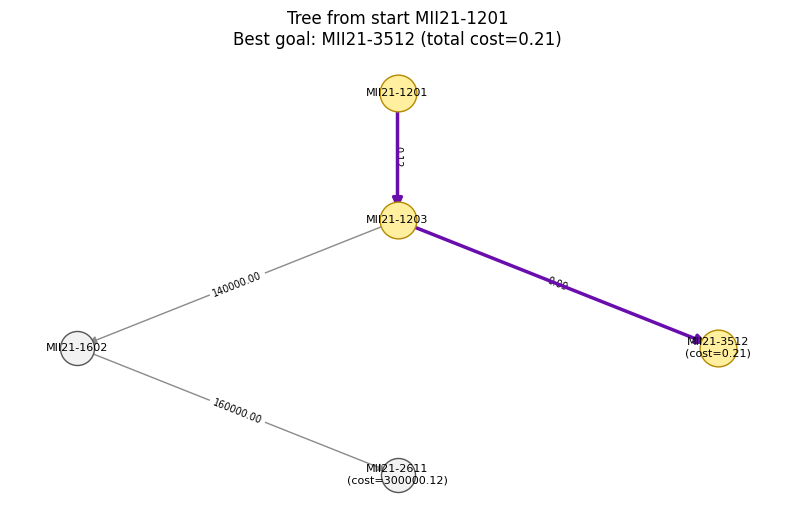

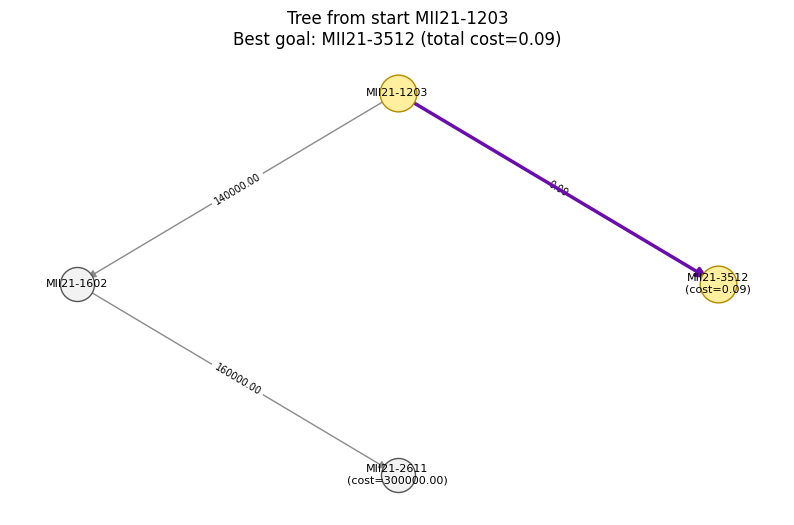

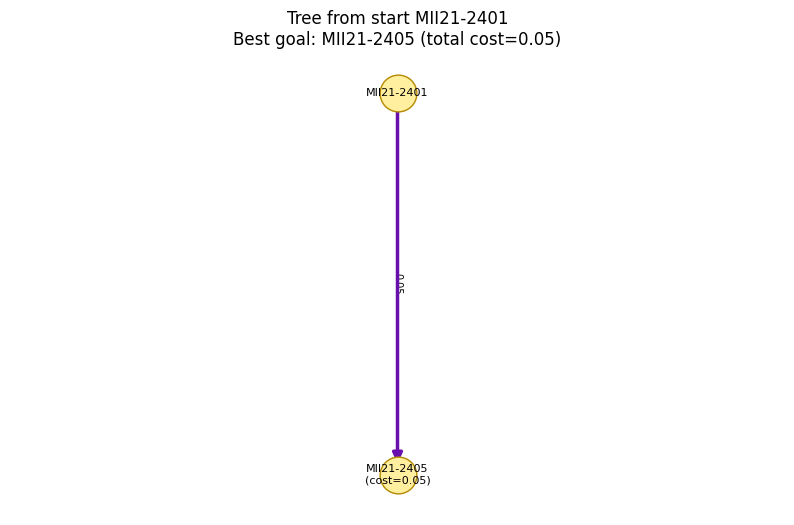

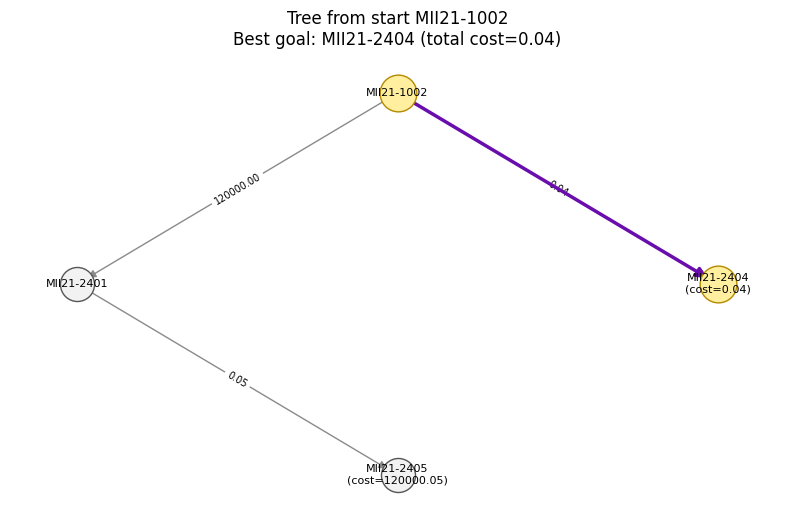

In [23]:
# Tree visualization per start node (taken)
import math
from collections import deque, defaultdict

def shortest_path_and_cost(start, goal):
    p = scp.astar(graph, start, goal, prereqs)
    if not p:
        return None, None
    cst = scp.path_cost(graph, p) if len(p) > 1 else (1.0 + 0.2 * scp.prereq_depth(prereqs, goal)) / (scp.score_course(course_map.get(goal, {}), interests, career_goal, career_keywords, lab_preferences) + 1e-5)
    return p, cst

def build_tree_for_start(start):
    # Collect union of A* shortest paths from start to each eligible candidate
    edges = []
    node_cost_to_goal = {}  # only store total cost to candidate nodes
    best_goal = None
    best_path = None
    best_cost = float('inf')

    for goal in eligible_candidates:
        path, cost = shortest_path_and_cost(start, goal)
        if not path:
            continue
        # store goal's total cost
        node_cost_to_goal[goal] = min(node_cost_to_goal.get(goal, float('inf')), cost)
        if cost < best_cost:
            best_cost = cost
            best_goal = goal
            best_path = path
        # add edges from this path
        for i in range(len(path) - 1):
            u, v = path[i], path[i+1]
            # find edge weight
            w = None
            for nb, c in graph.get(u, []):
                if nb == v:
                    w = c
                    break
            if w is None:
                w = 0.0
            edges.append((u, v, w))

    # Build tree graph (union of path edges)
    T = nx.DiGraph()
    for u, v, w in edges:
        if not T.has_edge(u, v):
            T.add_edge(u, v, weight=w)
    if not T.has_node(start):
        T.add_node(start)
    return T, node_cost_to_goal, best_goal, best_path, best_cost

def layered_positions(tree, root):
    # Simple BFS layers by hop count
    depth = {root: 0}
    q = deque([root])
    while q:
        u = q.popleft()
        for v in tree.successors(u):
            if v not in depth:
                depth[v] = depth[u] + 1
                q.append(v)
    # group nodes by depth
    levels = defaultdict(list)
    for n, d in depth.items():
        levels[d].append(n)
    # assign positions
    pos = {}
    max_width = max((len(nodes) for nodes in levels.values()), default=1)
    for d, nodes in levels.items():
        count = len(nodes)
        for i, n in enumerate(sorted(nodes)):
            x = (i + 1) / (count + 1)  # spread horizontally
            y = -d  # deeper is lower
            pos[n] = (x, y)
    # ensure all nodes present
    for n in tree.nodes():
        if n not in pos:
            pos[n] = (0.5, - (depth.get(n, 0)))
    return pos

def draw_tree_for_start(start):
    T, goal_costs, best_goal, best_path, best_cost = build_tree_for_start(start)
    if T.number_of_nodes() == 1 and start not in goal_costs:
        print(f"Start {start}: no paths to eligible candidates.")
        return
    pos = layered_positions(T, start)
    plt.figure(figsize=(10, 6))
    # draw base tree
    nx.draw_networkx_edges(T, pos, arrows=True, arrowsize=12, width=1.0, edge_color="#8a8a8a")
    nx.draw_networkx_nodes(T, pos, node_color="#f2f2f2", edgecolors="#555555", node_size=600)
    # node labels: code, and for goals show total cost
    labels = {}
    for n in T.nodes():
        lbl = n
        if n in goal_costs:
            lbl += f"\n(cost={goal_costs[n]:.2f})"
        labels[n] = lbl
    nx.draw_networkx_labels(T, pos, labels=labels, font_size=8)
    # edge labels: weight
    elabs = {(u, v): f"{d['weight']:.2f}" for u, v, d in T.edges(data=True)}
    nx.draw_networkx_edge_labels(T, pos, edge_labels=elabs, font_size=7)
    # highlight best path
    if best_path and len(best_path) > 1:
        ed = list(zip(best_path, best_path[1:]))
        nx.draw_networkx_edges(T, pos, edgelist=ed, edge_color="#6a0dad", width=2.5, arrows=True, arrowsize=14)
        nx.draw_networkx_nodes(T, pos, nodelist=best_path, node_color="#ffef9f", edgecolors="#b58900", node_size=700)
        plt.title(f"Tree from start {start}\nBest goal: {best_goal} (total cost={best_cost:.2f})")
    else:
        plt.title(f"Tree from start {start}")
    plt.axis('off')
    plt.show()

# Draw a tree per start node (taken)
for s in [x for x in courses_taken if x in graph]:
    draw_tree_for_start(s)

In [24]:
# Print input summary and eligible overview
print("Inputs:")
print("- interests:", interests)
print("- career_goal:", career_goal)
print("- current_semester:", current_semester)
print("- start_sem:", start_sem)
print("- courses_taken:", courses_taken)
print()
print(f"Eligible candidates for semester {start_sem} ({len(eligible_candidates)} total):")
for code in sorted(eligible_candidates):
    name = course_map.get(code, {}).get("course_name_en") or course_map.get(code, {}).get("course_name_id")
    print(f"  • {code} - {name}")

Inputs:
- interests: ['machine learning', 'AI']
- career_goal: data scientist
- current_semester: 3
- start_sem: 4
- courses_taken: ['MII21-1201', 'MII21-1203', 'MII21-2401', 'MII21-1002']

Eligible candidates for semester 4 (6 total):
  • MII21-2205 - Computer Graphics
  • MII21-2404 - Fuzzy Logic
  • MII21-2405 - Pattern Recognition
  • MII21-2608 - Special Topic on Computer and Network Systems
  • MII21-2611 - Next Generation Networks
  • MII21-3512 - Mobile Application Development


In [28]:
import sys
import pprint

# Supaya tidak ada batasan output panjang di notebook
sys.setrecursionlimit(10**6)
pp = pprint.PrettyPrinter(width=10000, compact=False)  # lebar besar supaya tidak dipotong

# Supaya Jupyter tidak memotong output besar dan menampilkan semua baris/kolom jika menggunakan pandas/numpy
try:
    import numpy as np
    np.set_printoptions(threshold=np.inf, linewidth=10000, suppress=True)  # tampilkan seluruh array tanpa ellipsis
except Exception:
    pass

try:
    import pandas as pd
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 0)  # biar auto menyesuaikan lebar
    pd.set_option('display.max_colwidth', None)
except Exception:
    pass

# Pastikan stdout tidak di-buffer sehingga seluruh output muncul, tanpa dipotong oleh buffering
try:
    sys.stdout.reconfigure(line_buffering=True)
except Exception:
    pass

# Tampilkan semua output dari setiap cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [30]:
# Compute and print f(n) details per candidate (best start)
import heapq

def astar_verbose(graph, start, goal, prereq_rules):
    open_set = [(0, start)]
    came_from = {}
    g_score = {start: 0.0}
    f_score = {start: scp.heuristic(start, goal, prereq_rules)}
    visited_order = []
    while open_set:
        _, current = heapq.heappop(open_set)
        visited_order.append(current)
        if current == goal:
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return list(reversed(path)), g_score, f_score, visited_order
        for neighbor, cost in graph.get(current, []):
            tentative_g = g_score[current] + cost
            if tentative_g < g_score.get(neighbor, float('inf')):
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g
                f_score[neighbor] = tentative_g + scp.heuristic(neighbor, goal, prereq_rules)
                heapq.heappush(open_set, (f_score[neighbor], neighbor))
    return None, g_score, f_score, visited_order

# Reuse candidate comparisons from earlier cell if present; otherwise recompute quickly
if 'comparisons' not in globals():
    start_nodes = [s for s in courses_taken if s in graph]
    comparisons = []
    for code in eligible_candidates:
        best_cost = float('inf'); best_start=None; best_path=None
        for s in start_nodes:
            p = scp.astar(graph, s, code, prereqs)
            if not p:
                continue
            cst = scp.path_cost(graph, p) if len(p) > 1 else (1.0 + 0.2 * scp.prereq_depth(prereqs, code)) / (scp.score_course(course_map.get(code, {}), interests, career_goal, career_keywords, lab_preferences) + 1e-5)
            if cst < best_cost:
                best_cost = cst; best_start = s; best_path = p
        if best_cost == float('inf'):
            best_cost = (1.0 + 0.2 * scp.prereq_depth(prereqs, code)) / (scp.score_course(course_map.get(code, {}), interests, career_goal, career_keywords, lab_preferences) + 1e-5)
            best_start = None; best_path=[code]
        sc = scp.score_course(course_map.get(code, {}), interests, career_goal, career_keywords, lab_preferences)
        comparisons.append({"code": code, "score": sc, "best_cost": best_cost, "best_start": best_start, "path": best_path})

sorted_comp = sorted(comparisons, key=lambda r: (r['best_cost'], -r['score'], r['code']))
print("\nDetailed f(n) per candidate (using best start):\n", flush=True)
for idx, row in enumerate(sorted_comp, start=1):
    code = row['code']
    name = course_map.get(code, {}).get('course_name_en') or course_map.get(code, {}).get('course_name_id')
    start = row['best_start']
    path, g_score, f_score, visited = astar_verbose(graph, start, code, prereqs) if start else (row['path'], {}, {}, [])
    # Path metrics
    if path and len(path) > 1:
        g_goal = sum(next((c for nb, c in graph.get(path[i], []) if nb == path[i+1]), 0.0) for i in range(len(path)-1))
    else:
        # fallback own cost when no path or trivial
        depth = scp.prereq_depth(prereqs, code)
        sc = scp.score_course(course_map.get(code, {}), interests, career_goal, career_keywords, lab_preferences)
        g_goal = (1.0 + 0.2 * depth) / (sc + 1e-5)
    h_goal = 0.0
    f_goal = g_goal + h_goal
    print(f"[{idx}] {code} - {name}", flush=True)
    print(f"    start: {start}", flush=True)
    print(f"    path: {' → '.join(path) if path else '—'}", flush=True)
    print(f"    g(goal)={g_goal:.4f}, h(goal)={h_goal:.2f}, f(goal)={f_goal:.4f}", flush=True)
    # Show f(n) along the path if we have verbose scores
    if start and path:
        print("    f(n) along path:", flush=True)
        for n in path:
            g = g_score.get(n, float('nan'))
            h = scp.heuristic(n, code, prereqs)
            f = g + h if g == g else float('nan')
            print(f"      - {n:12s} | g(n)={g:7.4f} | h(n)={h:5.2f} | f(n)={f:7.4f}", flush=True)
    print(flush=True)


Detailed f(n) per candidate (using best start):



[1] MII21-2404 - Fuzzy Logic
    start: MII21-1002
    path: MII21-1002 → MII21-2404
    g(goal)=0.0400, h(goal)=0.00, f(goal)=0.0400
    f(n) along path:
      - MII21-1002   | g(n)= 0.0000 | h(n)= 1.00 | f(n)= 1.0000
    start: MII21-1002
    path: MII21-1002 → MII21-2404
    g(goal)=0.0400, h(goal)=0.00, f(goal)=0.0400
    f(n) along path:
      - MII21-1002   | g(n)= 0.0000 | h(n)= 1.00 | f(n)= 1.0000
      - MII21-2404   | g(n)= 0.0400 | h(n)= 0.00 | f(n)= 0.0400

[2] MII21-2405 - Pattern Recognition
      - MII21-2404   | g(n)= 0.0400 | h(n)= 0.00 | f(n)= 0.0400

[2] MII21-2405 - Pattern Recognition
    start: MII21-2401
    path: MII21-2401 → MII21-2405
    g(goal)=0.0533, h(goal)=0.00, f(goal)=0.0533
    f(n) along path:
      - MII21-2401   | g(n)= 0.0000 | h(n)= 2.00 | f(n)= 2.0000
      - MII21-2405   | g(n)= 0.0533 | h(n)= 0.00 | f(n)= 0.0533

[3] MII21-2205 - Computer Graphics
    start: None
    path: MII21-2205
    g(goal)=0.0833, h(goal)=0.00, f(goal)=0.0833

[4] MII21-

<Figure size 1400x900 with 0 Axes>

{'MII21-1002': Text(-0.9999999999999999, 0.984898746622984, 'MII21-1002'),
 'MII21-2404': Text(0.9999999999999999, -0.984898746622984, 'MII21-2404')}

{('MII21-1002', 'MII21-2404'): Text(0.0, 0.0, '0.04')}

Text(0.5, 1.0, 'Semester 4 — chosen: MII21-2404 (cost=0.0400, score=30.00)\nFuzzy Logic')

(-1.21, 1.21, -1.1917274834138107, 1.1917274834138107)

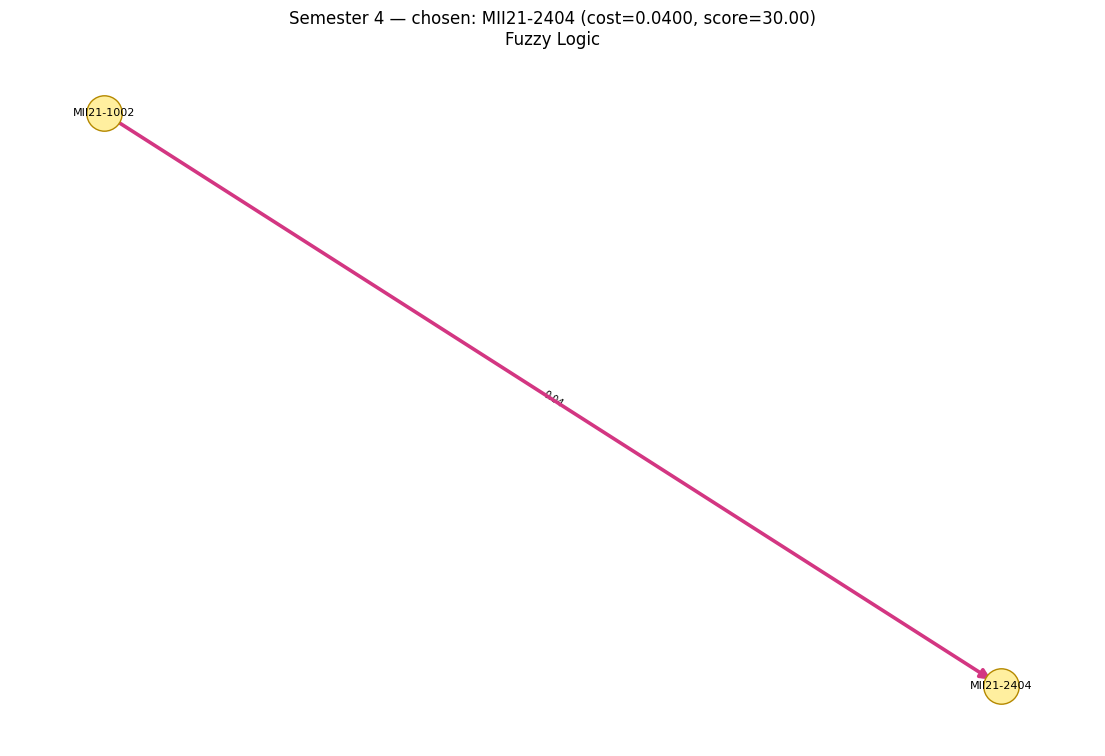

<Figure size 1400x900 with 0 Axes>

{'MII21-2401': Text(-0.9999999999999999, 0.9848987466229844, 'MII21-2401'),
 'MII21-3403': Text(0.9999999999999999, -0.9848987466229844, 'MII21-3403')}

{('MII21-2401', 'MII21-3403'): Text(0.0, 0.0, '0.05')}

Text(0.5, 1.0, 'Semester 5 — chosen: MII21-3403 (cost=0.0467, score=30.00)\nBioinformatics')

(-1.21, 1.21, -1.191727483413811, 1.191727483413811)

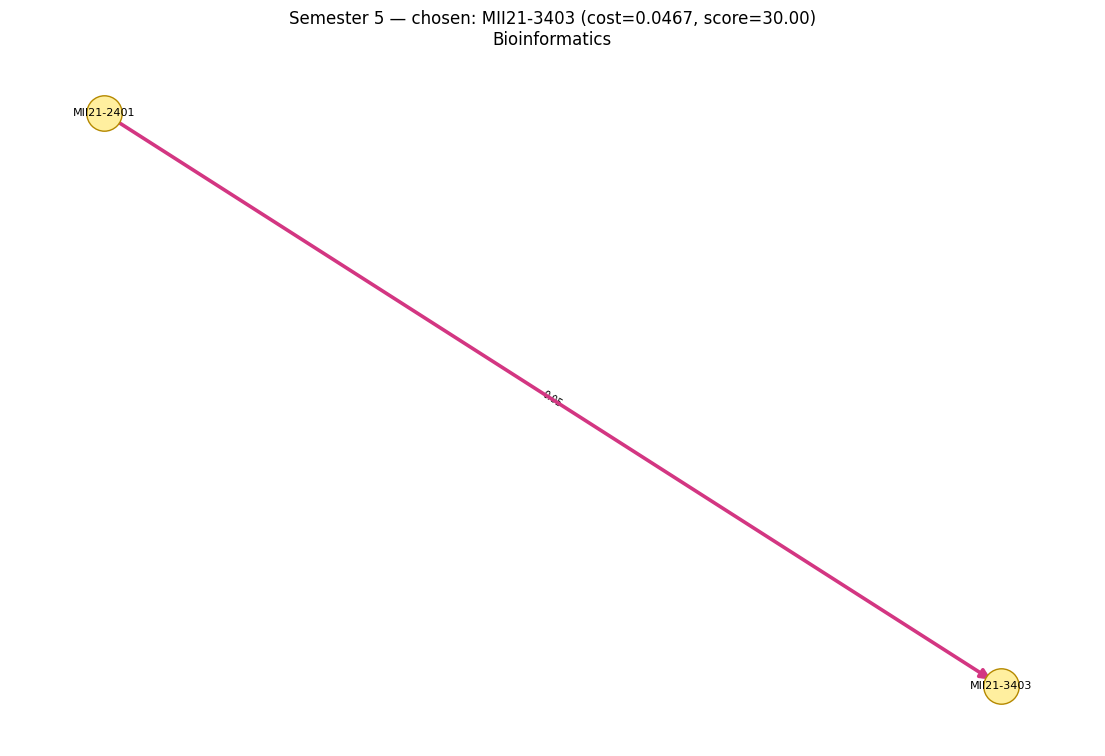

<Figure size 1400x900 with 0 Axes>

{'MII21-1201': Text(-0.9999999999999999, 0.984898746622984, 'MII21-1201'),
 'MII21-3406': Text(0.9999999999999999, -0.984898746622984, 'MII21-3406')}

{('MII21-1201', 'MII21-3406'): Text(0.0, 0.0, '0.04')}

Text(0.5, 1.0, 'Semester 6 — chosen: MII21-3406 (cost=0.0400, score=30.00)\nDecision Support Systems')

(-1.21, 1.21, -1.1917274834138107, 1.1917274834138107)

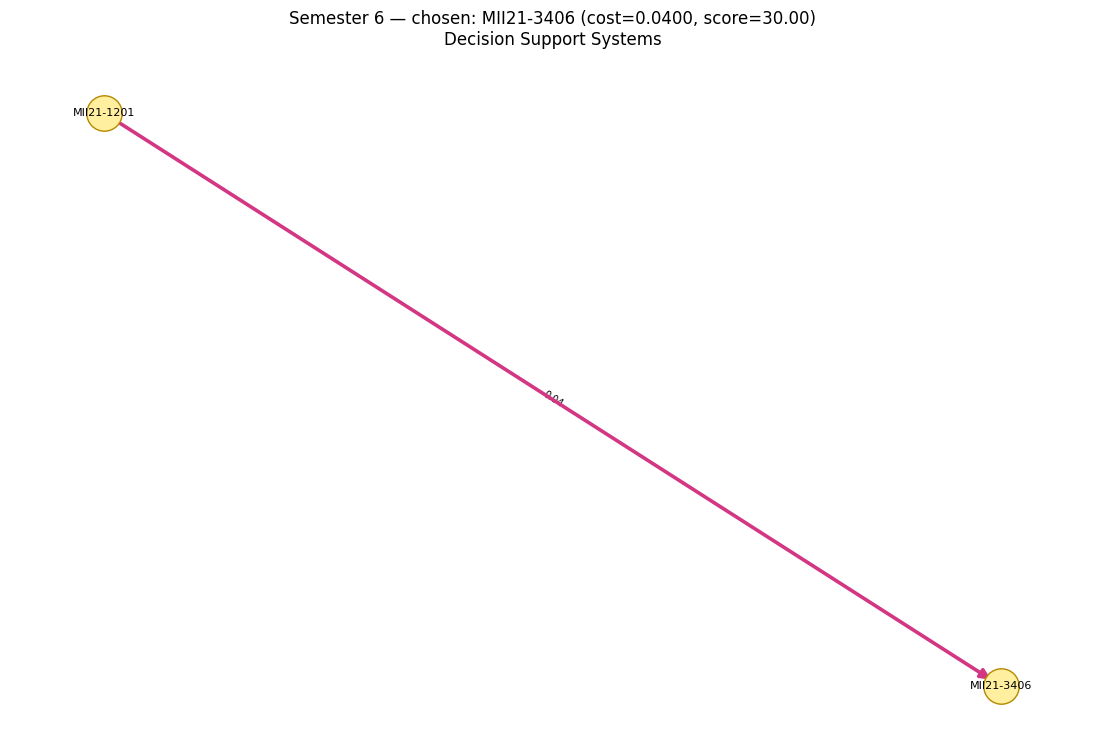

<Figure size 1400x900 with 0 Axes>

[]

{}

{}

Text(0.5, 1.0, 'Semester 7 — chosen: MII21-3204 (cost=0.0833, score=12.00)\nResearch Trends in Algorithm and Computation')

(0.0, 1.0, 0.0, 1.0)

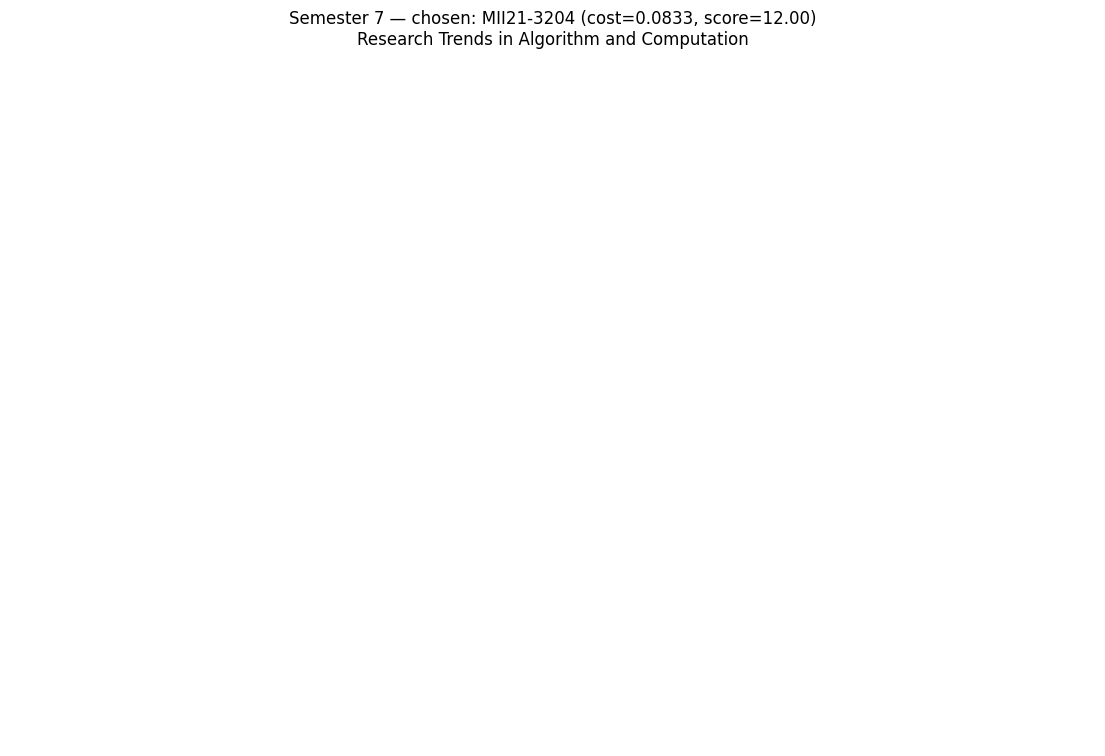


Summary plan (from multi-semester visualization):
Semester 4: - MII21-2404 (3) - Fuzzy Logic | cost=0.0400 score=30.00
Semester 5: - MII21-3403 (3) - Bioinformatics | cost=0.0467 score=30.00
Semester 6: - MII21-3406 (3) - Decision Support Systems | cost=0.0400 score=30.00
Semester 7: - MII21-3204 (3) - Research Trends in Algorithm and Computation | cost=0.0833 score=12.00


In [31]:
# Multi-semester A* visualization for given profile
name = "deira"  # for display only
start_sem = current_semester + 1  # should already be 4 for current_semester=3

# Helper: planner-fidelity candidate selection for one semester
def own_cost_for(code):
    sc = scp.score_course(course_map.get(code, {}), interests, career_goal, career_keywords, lab_preferences)
    depth = scp.prereq_depth(prereqs, code)
    return (1.0 + 0.2 * depth) / (sc + 1e-5)

def select_best_for_semester(taken_set, sem):
    # Filter candidates identical to planner: elective-only, offered this sem, prereq_ok, not taken
    cand = [
        code for code in course_map.keys()
        if scp.is_elective(course_map.get(code, {}))
        and scp.offered_in_semester(course_map.get(code, {}), sem)
        and scp.prereq_ok(code, taken_set, prereqs)
        and code not in taken_set
    ]
    best = None  # tuple: (cost, -score, code, start_used, path)
    for code in cand:
        entry = prereqs.get(code, {})
        pre_list = [p.get("code") for p in entry.get("prerequisites", []) if p.get("code")]
        start_nodes = pre_list if pre_list else [code]
        # cost baseline
        sc = scp.score_course(course_map.get(code, {}), interests, career_goal, career_keywords, lab_preferences)
        depth = scp.prereq_depth(prereqs, code)
        oc = (1.0 + 0.2 * depth) / (sc + 1e-5)
        best_cost = float("inf"); best_start=None; best_path=None
        for s in start_nodes:
            # we allow starts outside taken_set; planner uses direct prereqs as starts
            path = scp.astar(graph, s, code, prereqs)
            if not path:
                continue
            cst = scp.path_cost(graph, path) if len(path) > 1 else oc
            if cst < best_cost:
                best_cost, best_start, best_path = cst, s, path
        if best_cost == float("inf"):
            best_cost, best_start, best_path = oc, None, [code]
        item = (best_cost, -sc, code, best_start, best_path)
        if best is None or item < best:
            best = item
    return best  # or None if no candidates

# Iterate semesters and draw
multi_taken = set(courses_taken)
picks = []
for sem in range(start_sem, 8):
    sel = select_best_for_semester(multi_taken, sem)
    if not sel:
        print(f"Semester {sem}: no eligible electives.")
        picks.append((sem, None, None, None))
        continue
    cost, neg_sc, code, start_used, path = sel
    score = -neg_sc
    picks.append((sem, code, score, cost))
    # evolve taken as planner does
    multi_taken.add(code)
    # Build a subgraph of all nodes that point to any candidate this sem (for context)
    cand_nodes = [
        c for c in course_map.keys()
        if scp.is_elective(course_map.get(c, {}))
        and scp.offered_in_semester(course_map.get(c, {}), sem)
        and scp.prereq_ok(c, multi_taken - {code}, prereqs)
        and c not in (multi_taken - {code})
    ]
    Gs = nx.DiGraph()
    for u in cand_nodes:
        for v, w in graph.get(u, []):
            if v in cand_nodes:
                Gs.add_edge(u, v, weight=w)
    # Ensure path nodes/edges are present
    for i in range(len(path) - 1):
        u, v = path[i], path[i+1]
        # fetch edge weight if exists
        ew = None
        for nb, w in graph.get(u, []):
            if nb == v:
                ew = w; break
        if ew is None:
            ew = own_cost_for(v)
        if not Gs.has_node(u):
            Gs.add_node(u)
        if not Gs.has_node(v):
            Gs.add_node(v)
        if not Gs.has_edge(u, v):
            Gs.add_edge(u, v, weight=ew)
    pos = nx.spring_layout(Gs, seed=42)
    plt.figure(figsize=(14, 9))
    # base graph
    nx.draw_networkx_nodes(Gs, pos, node_size=520, node_color="#eaeaea", edgecolors="#666666")
    nx.draw_networkx_edges(Gs, pos, edge_color="#bdbdbd", arrows=True, arrowsize=12, width=1.0)
    nx.draw_networkx_labels(Gs, pos, labels={n: n for n in Gs.nodes()}, font_size=8)
    elabs = {(u, v): f"{d['weight']:.2f}" for u, v, d in Gs.edges(data=True)}
    nx.draw_networkx_edge_labels(Gs, pos, edge_labels=elabs, font_size=7)
    # highlight chosen path
    if path and len(path) > 1:
        ed = list(zip(path, path[1:]))
        nx.draw_networkx_edges(Gs, pos, edgelist=ed, edge_color="#d33682", width=2.6, arrows=True, arrowsize=14)
        nx.draw_networkx_nodes(Gs, pos, nodelist=path, node_color="#ffef9f", edgecolors="#b58900", node_size=650)
    title_name = course_map.get(code, {}).get("course_name_en") or course_map.get(code, {}).get("course_name_id") or code
    plt.title(f"Semester {sem} — chosen: {code} (cost={cost:.4f}, score={score:.2f})\n{title_name}")
    plt.axis("off")
    plt.show()

print("\nSummary plan (from multi-semester visualization):")
for sem, code, score, cost in picks:
    if not code:
        print(f"Semester {sem}: [No electives]")
    else:
        name = course_map.get(code, {}).get("course_name_en") or course_map.get(code, {}).get("course_name_id") or code
        sks = course_map.get(code, {}).get("sks")
        print(f"Semester {sem}: - {code} ({sks}) - {name} | cost={cost:.4f} score={score:.2f}")